# Sentiment Analysis in Course Review using DistilBERT Transfer Learning

## Background
Dalam perusahaan edukasi, feedback siswa merupakan komponen penting dalam meningkatkan kualitas pembelajaran. Biasanya, feedback tersebut dalam bentuk tulisan atau teks. Feedback teks mengandung berbagai macam insight sehingga dapat dieksplorasi lebih lanjut.

Dalam data bentuk teks, kita dapat menemukan sentimen dari teks tersebut, yaitu mengetahui apakah feedback tersebut bersifat positif, netral, atau negatif. Namun, bila jumlah feedback besar akan sangat sulit untuk mengecek satu-satu sentimennya. Oleh karena itu perlu proses yang otomatis untuk mendapatkan sentimen dari teks tersebut, yaitu dengan menggunakan analisis sentimen.

## Install Package
Untuk menggunakan arsitektur pretrained DistilBert, diperlukan sebuah package yang bernama `Transformers`. Transformers adalah sebuah package yang menyediakan berbagai macam pretrained model bahasa dari arsitektur berbasis tranformers.

In [1]:
# !pip install transformers

## Set Device
Proses pelatihan neural network akan membutuhkan resource yang besar, sehingga kita akan membutuhkan GPU. Berikut ini adalah code untuk melakukan pengecekan apakah dalam device yang digunakan terdapat GPU atau tidak. Jika tidak ada GPU maka akan otomatis menggunakan CPU saja.

In [2]:
#mengecek apakah terdapat GPU pada komputer
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
#jika tidak ada maka gunakan CPU untuk menjalankan program
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


## Import Packages
Berikut ini adalah beberapa package yang digunakan untuk membangun model dan melakukan analisis. Diantaranya adalah sebagai berikut.

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import torch
import transformers
from transformers import DistilBertModel, DistilBertTokenizer
from torch.optim import Adam

import os
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Jangan lupa untuk set random seed, agar ketika code dijalankan berkali-kali hasilnya tidak berubah-ubah.

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Read Dataset
Dalam notebook ini, akan digunakan dataset 100k Courseras Course Review. Dataset tersebut merupakan review dari kursus-kursus online yang berasal dari situs Coursera. Dataset tersebut dapat diakses pada <a href = "https://www.kaggle.com/datasets/septa97/100k-courseras-course-reviews-dataset"> link </a> berikut ini.

In [5]:
df = pd.read_csv("/kaggle/input/100k-courseras-course-reviews-dataset/reviews.csv")
df.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


**Keterangan**
* `id` : ID Review
* `Review` : Teks Review
* `Label` : Rating dari Review (1-5)

## Label Sentiment
Dalam notebook ini, akan dilakukan konversi terhadap label-label tersebut menjadi nilai sentimen (positive, neutral, negative).
* Jika rating 4 - 5, maka nilai sentimennya adalah positive
* Jika rating 3, maka nilai sentimennya adalah neutral
* Jika rating 1 - 2, maka nilai sentimennya adalah negative

In [6]:
def sentiment_label(x):
    if ((x == 4) or (x == 5)):
        return "positive"
    elif (x == 3):
        return "neutral"
    elif ((x == 1) or (x == 2)):
        return "negative"
    
df["Sentiment"] = df["Label"].apply(lambda x : sentiment_label(x))

In [7]:
df.head()

,Id,Review,Label,Sentiment
0,0,good and interesting,5,positive
1,1,"This class is very helpful to me. Currently, I...",5,positive
2,2,like!Prof and TAs are helpful and the discussi...,5,positive
3,3,Easy to follow and includes a lot basic and im...,5,positive
4,4,Really nice teacher!I could got the point eazl...,4,positive


## Class Distribution
Pada bagian ini, akan dilakukan pengecekan distribusi kelas terlebih dahulu untuk melakukan penanganan selanjutnya.

<AxesSubplot: ylabel='Sentiment'>

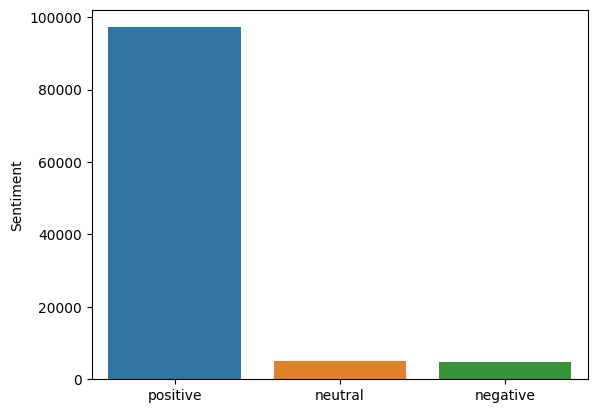

In [8]:
# check class distribution
import seaborn as sns
sns.barplot(x = df["Sentiment"].value_counts().index, y = df["Sentiment"].value_counts())

Data tersebut merupakan data yang imbalance, sehingga perlu adanya penanganan lebih lanjut ketika akan melakukan pelatihan. Namun sebelumnya kita perlu memproses dan menganalisis lebih lanjut data teks yang dimiliki.

## Text Analysis
Sebelum melakukan analisis lebih lanjut, kita perlu melakukan preprocessing teks terlebih dahulu agar dapat melakukan analisis.

### Word Cloud
Kita akan mencoba untuk menganalisis wordcloud dari setiap sentimen yang ada. Namun sebelumnya kita perlu melakukan preprocessing terhadap data agar dapat menemukan insight yang berarti.

#### Text Preprocessing
Berikut ini adalah preprocessing yang dilakukan. 
1. **Pemanjangan kata slang inggris.** Contohnya adalah IMO menjadi in my opinion. Daftar kata slang terdapat pada <a href = "https://www.kaggle.com/datasets/aksharagadwe/abbreviations-and-slangs-for-text-preprocessing"> link </a> berikut.
2. **Pengoreksian aphrostope pada kata inggris.** Contohnya adalah dont menjadi don't.

In [9]:
abb_slangs = pd.read_csv("/kaggle/input/abbreviations-and-slangs-for-text-preprocessing/Abbreviations and Slang.csv")
slangs_dict = dict(zip(abb_slangs["Abbreviations"],abb_slangs["Text"]))

#add more dictionary
slangs_dict["luv"] = "love"

Preprocessing tersebut dibungkus dalam fungsi-fungsi berikut ini

In [10]:
# normalisasi teks-teks yang typo
def abb_slangs_conv(x):
    if x in slangs_dict.keys():
        return slangs_dict[x]
    else:
        return x

def prep_text(text):
    cur_text = text.replace('cant', "can't")
    cur_text = cur_text.replace('wouldnt', "wouldn't")
    cur_text = cur_text.replace('dont', "don't")
    cur_text = cur_text.replace('didnt', "didn't")
    cur_text = cur_text.replace('doesnt',"doesn't")
    cur_text = cur_text.replace('wont',"won't")
    cur_text = cur_text.replace("youre", "you're")
    
    curr_words = word_tokenize(str.lower(cur_text))
    cleaned_text = ' '.join([abb_slangs_conv(w) for w in curr_words])  
            
    return cleaned_text

Kemudian, lakukan preprocessing yang dimasukkan ke dalam kolom `preprocessed_review`

In [11]:
df["preprocessed_review"] = df["Review"].apply(lambda x : prep_text(x))

Ketika melakukan analisis teks dengan visualisasi wordcloud, kita perlu melakukan lematisasi atau mengubah kata yang mempunyai imbuhan menjadi kata dasar. Oleh karena itu, kita akan menggunakan package `nltk` untuk melakukan lemmatisasi. Namun sebelumnya, kita perlu mendownload `wordnet` terlebih dahulu.

In [12]:
# import these modules
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

Kemudian, lakukan lemmatisasi pada masing-masing teks berdasarkan labelnya. Pertama, kita perlu memisahkan teks review berdasarkan labelnya dan menggabungkan semua review menjadi satu string.

In [13]:
text_positive = df[df["Sentiment"]=="positive"]
text_negative = df[df["Sentiment"]=="negative"]
text_neutral = df[df["Sentiment"]=="neutral"]

text_positives = " ".join(review for review in text_positive.preprocessed_review)
text_negatives = " ".join(review for review in text_negative.preprocessed_review)
text_neutrals = " ".join(review for review in text_neutral.preprocessed_review)

Lalu kemudian, lakukan lemmatisasi. Disini kita akan mengemasnya dalam sebuah fungsi.

In [14]:
lemmatizer = WordNetLemmatizer()

def lemma_text(x):
    word_list = word_tokenize(x)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(str.lower(w)) for w in word_list])
    return lemmatized_output

In [15]:
text_positives = lemma_text(text_positives)
text_negatives = lemma_text(text_negatives)
text_neutrals = lemma_text(text_neutrals)

Kemudian, kita akan menghapus stopwords agar dapat menangkap kata-kata yang bersifat penting dalam analisis. package `wordcloud` dapat secara otomatis menghapus stopwords dengan menginisiasi stopwordsnya terlebih dahulu.

In [16]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["n't","'m","'re","'ll", "'s"])

#### Analisis Label Positif

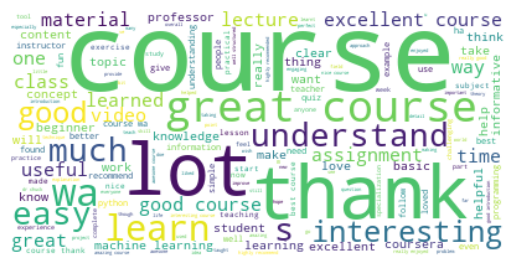

In [17]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_positives)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Berdasarkan wordcloud diatas, Kata yang menjadi sentimen positif adalah course, dan terdapat beberapa kata yang menunjukkan pujian untuk sebuah course di coursera, seperti "great course", "excellent course", dan "good course". Kemudian terdapat beberapa aspek yang dibahas meliputi "instructor", "material", dan "assignment". Hal ini menunjukkan bahwa aspek-aspek tersebut merupakan hal-hal yang menjadi kepuasan bagi customer dalam belajar.


#### Analisis Label Negatif

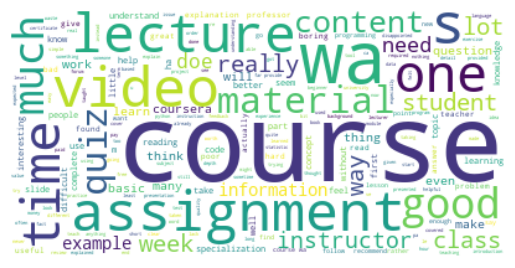

In [18]:
# Create stopword list:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_negatives)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Berdasarkan wordcloud tersebut, beberapa kata yang muncul adalah kata course, video, assignement, dan lain sebagainya. Ketiga kata ini adalah aspek yang diperhatikan oleh siswa ketika belajar. Kemungkinan besar siswa mempunyai komplain terkait dengan kursus yang dibawakan, assignment yang dikerjakan, serta video materi.

#### Analisis Label Neutral

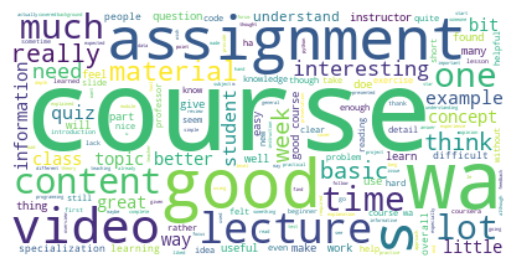

In [19]:
# Create stopword list:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_neutrals)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Checking Sentence Length
Pada bagian ini, akan dilakukan pengecekan panjang kalimat dengan menghitung jumlah kata per kalimat.

In [20]:
# check len sentence
from nltk.tokenize import word_tokenize

df['length_sen'] = df['preprocessed_review'].apply(lambda x : len(word_tokenize(x)))

Berikut ini adalah maksimal panjang kalimat dari dataset tersebut.

In [21]:
# max length
max_len = max(df['length_sen'])
print("Max Length : ", max(df['length_sen']))

Max Length :  1460


Maksimal panjang kalimat adalah 1460 kata.

## BERT (Bidirectional Encoder Representations from Transformers)
- Tambah penjelasan bert model --> dibaliknya apa, basic algoritma
- penjelasan framework pytorch

- Sumber : https://arxiv.org/pdf/1810.04805.pdf, https://huggingface.co/

Distilbert
- Sumber : https://arxiv.org/abs/1910.01108.pdf

### Label Encoder

In [22]:
df['sent_lab'] = df['Sentiment'].astype("category")
df['sent_lab'] = df['sent_lab'].cat.rename_categories(
    {
        "negative" : 0,
        "neutral" : 1,
        "positive" : 2
    }
)

### Cross Validation

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["preprocessed_review"], df["sent_lab"], test_size=0.2, random_state=42, stratify = df["Sentiment"])
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify = y_test)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(85614,)
(10702,)
(10702,)


In [25]:
y_train.value_counts()

2    77781
1     4057
0     3776
Name: sent_lab, dtype: int64

In [26]:
y_test.value_counts()

2    9723
1     507
0     472
Name: sent_lab, dtype: int64

In [27]:
y_val.value_counts()

2    9723
1     507
0     472
Name: sent_lab, dtype: int64

### Build DistilBert Transfer Learning
Untuk melakukan transfer learning, kita perlu mendownload model pretrained dari huggingface. Selain itu kita memerlukan tokenizer.

In [28]:
#import bert tokenizer, pilih yang multilingual karena lebih dari 1 bahasa

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenizer

In [29]:
enc = tokenizer.encode(X_train[0])
print(enc)
print(tokenizer.convert_ids_to_tokens(enc))

[101, 2204, 1998, 5875, 102]
['[CLS]', 'good', 'and', 'interesting', '[SEP]']


### Data Loader

In [30]:
#fungsi untuk loading dataset
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
  def __init__(self, reviews, labels, max_len, tokenizer):
    self.reviews = reviews.reset_index()["preprocessed_review"]
    self.labels = labels.reset_index()["sent_lab"]
    self.max_len = max_len
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    reviews = self.reviews[idx]
    labels = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
      reviews,                      
      add_special_tokens=True,    
      max_length=self.max_len,    
      padding='max_length',     
      truncation=True,            
      return_attention_mask=True, 
      return_tensors='pt'         
    )

    return {
        'review': reviews,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(labels, dtype=torch.long)
    }

In [31]:
#512 adalah maxnya bert
train_data = ReviewDataset(X_train,y_train, 512, tokenizer)
val_data = ReviewDataset(X_val,y_val, 512, tokenizer)
test_data = ReviewDataset(X_test,y_test, 512, tokenizer)

In [32]:
# pemilihan batch size berasal dari paper https://arxiv.org/pdf/1810.04805.pdf
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

### DistilBert Transfer Learning

In [33]:
from torch import nn
class Bert_TL(nn.Module):
  def __init__(self,bert):
    super(Bert_TL, self).__init__()
    self.bert = bert
    self.fc1 = nn.Linear(768,512)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(512,3)
  
  def forward(self, input_ids, attention_mask):
    hidden = self.bert(input_ids = input_ids, attention_mask = attention_mask)
    x = self.fc1(hidden[0][:, 0, :])
    x = self.relu(x)
    x = self.fc2(x)
    
    return x

In [34]:
model = Bert_TL(model)
model.to(device)

Bert_TL(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

Kemudian, kita akan mencoba untuk freeze weight pada model tersebut

In [35]:
for param in model.bert.parameters():
    param.requires_grad = False

### Penanganan kelas imbalance

In [36]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(y_train), 
                                     y = y_train)

class_weights_t = torch.tensor(class_weights, dtype=torch.float)

class_weights_t = class_weights_t.to(device)

print("Class Weights:",class_weights)
print(np.unique(y_train))

Class Weights: [7.55773305 7.03426177 0.36690194]
[0 1 2]


### Inisiasi Hyperparameter
Pemilihan parameter berasal dari paper https://arxiv.org/pdf/1810.04805.pdf

In [37]:
# Inisiasi hyperparameter
learning_rate = 5e-5

#inisiasi loss function
loss_fn =nn.CrossEntropyLoss(weight=class_weights_t).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

### Fungsi Train dan Evaluasi

In [38]:
def train_loop(
  data_loader, 
  model, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  #menandakan bahwa model sedang dilatih
  model = model.train()

  losses = []
  correct_predictions = 0
  
  #iterasi di setiap data
  for d in data_loader:

    #mengambil input id, attention mask, dan target dari setiap data
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["label"].to(device)

    #mengeluarkan output dari data tersebut
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    #mengeluarkan prediksi target
    _, preds = torch.max(outputs, dim=1)

    #mengeluarkan lossnya
    loss = loss_fn(outputs, targets)

    #menjumlahkan prediksi target yang benar
    correct_predictions += torch.sum(preds == targets)

    #mengumpulkan loss dari output dan target
    losses.append(loss.item())

    loss.backward()

    #untuk menghindari vanishing gradient
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  #mengembalikan akurasi dan rata-rata loss
  return correct_predictions.double() / n_examples, np.mean(losses)


def test_loop(model, data_loader, loss_fn, device, n_examples):

  #menandakan model sedang dievaluasi
  model = model.eval()

  #array losses dari setiap data dan variabel correct_prediction untuk jumlah prediksi benar
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      #mengambil input id, attention mask, dan target dari setiap data
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      #mengambil output dari data
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      #mengambil kelas prediksi
      _, preds = torch.max(outputs, dim=1)
      
      #mengeluarkan loss dari output dan targets
      loss = loss_fn(outputs, targets)

      #menjumlahkan prediksi yang benar
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  #mengembalikan akurasi dan rata-rata loss
  return correct_predictions.double() / n_examples, np.mean(losses)

### Pelatihan DistilBERT

In [39]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc, train_loss = train_loop(train_dataloader, model, loss_fn, optimizer,device,len(X_train))
    val_acc, val_loss = test_loop(
      model,
      val_dataloader,
      loss_fn, 
      device, 
      len(X_val)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print("Done!")

Epoch 1
-------------------------------
Train loss 0.7268248797019857 accuracy 0.835867965519658
Val loss 0.64132280207392 accuracy 0.8250794244066529
Done!
Epoch 2
-------------------------------
Train loss 0.6443702003713948 accuracy 0.8406452215759105
Val loss 0.6173737107817806 accuracy 0.8410577462156607
Done!
Epoch 3
-------------------------------
Train loss 0.6328534317914235 accuracy 0.8427710421192796
Val loss 0.6212687474355769 accuracy 0.8699308540459727
Done!
Epoch 4
-------------------------------
Train loss 0.6275692850752261 accuracy 0.8446632560095312
Val loss 0.6075658143678708 accuracy 0.8429265557839656
Done!


### Prediksi dengan Test Set

In [40]:
# prediction with test set
import torch.nn.functional as F

def get_predictions(model, data_loader):
  model = model.eval()
  
  story_texts = []
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

In [41]:
from sklearn.metrics import classification_report
y_pred, y_test_lab = get_predictions(model, test_dataloader)

print(classification_report(y_test_lab, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.72      0.55       472
           1       0.20      0.58      0.29       507
           2       0.99      0.86      0.92      9723

    accuracy                           0.84     10702
   macro avg       0.54      0.72      0.59     10702
weighted avg       0.93      0.84      0.87     10702



### Save Model

In [42]:
torch.save(model, 'model.pt')

## Comparison with Bert Based
Kita akan mencoba untuk membandingkan DistilBERT dengan BERT biasa. Lakukan beberapa step yang sama dengan DistilBERT.

In [43]:
from transformers import BertModel, BertTokenizer

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Kemudian, buatlah data loader dengan menggunakan fungsi yang sama.

In [44]:
train_data_b = ReviewDataset(X_train,y_train, 512, tokenizer_bert)
val_data_b = ReviewDataset(X_val,y_val, 512, tokenizer_bert)
test_data_b = ReviewDataset(X_test,y_test, 512, tokenizer_bert)

In [45]:
train_dataloader_b = DataLoader(train_data_b, batch_size=32, shuffle=True)
val_dataloader_b = DataLoader(val_data_b, batch_size=32, shuffle=True)
test_dataloader_b = DataLoader(test_data_b, batch_size=32, shuffle=True)

Setelah itu, bangun transfer learning dengan menggunakan fungsi yang sama dengan yang sebelumnya.

In [46]:
model_bert = Bert_TL(model_bert)
model_bert.to(torch.device("cuda"))

Bert_TL(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Lakukan inisiasi ulang fungsi loss dan optimizernya

In [47]:
# Inisiasi hyperparameter
learning_rate = 5e-5

#inisiasi loss function
loss_fn =nn.CrossEntropyLoss(weight=class_weights_t).to(device)
optimizer = Adam(model_bert.parameters(), lr=learning_rate)

for param in model_bert.bert.parameters():
    param.requires_grad = False

Kemudian lakukan proses training kembali

In [48]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc, train_loss = train_loop(train_dataloader_b, model_bert, loss_fn, optimizer,device,len(X_train))
    val_acc, val_loss = test_loop(
      model_bert,
      val_dataloader_b,
      loss_fn, 
      device, 
      len(X_val)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print("Done!")

Epoch 1
-------------------------------
Train loss 0.7334489142758874 accuracy 0.8311841521246526
Val loss 0.6524974863920638 accuracy 0.8535787703233041
Done!
Epoch 2
-------------------------------
Train loss 0.6619076193999416 accuracy 0.8422337468171094
Val loss 0.6213592353151806 accuracy 0.8366660437301439
Done!
Epoch 3
-------------------------------
Train loss 0.6505143391232943 accuracy 0.8442427640339197
Val loss 0.6219887886696787 accuracy 0.8755372827508877
Done!
Epoch 4
-------------------------------
Train loss 0.6348384432411114 accuracy 0.8467540355549327
Val loss 0.6181920498609543 accuracy 0.8785273780601757
Done!


In [49]:
from sklearn.metrics import classification_report
y_pred_b, y_test_lab_b = get_predictions(model_bert, test_dataloader_b)

print(classification_report(y_test_lab_b, y_pred_b))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59       472
           1       0.24      0.54      0.34       507
           2       0.99      0.90      0.94      9723

    accuracy                           0.88     10702
   macro avg       0.58      0.72      0.62     10702
weighted avg       0.93      0.88      0.90     10702



In [50]:
torch.save(model_bert, 'model_bert.pt')